In [2]:
%load_ext autoreload
%autoreload 2
# %cd "/Users/fan/OneDrive\ -\ University\ of\ Southampton/Chandler\'s\ Projects/Edge-Cloud-Resource-Allocation-Using-MARL-and-Auction/scripts"
%cd "../benchmarks"
# %matplotlib inline
# import numpy as np
# import pandas as pd
# import importlib
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns
import csv
from scipy import stats
import os.path
import pdb
from statistics import mean 
from collections import OrderedDict
import sys
import pickle
# from tqdm import tqdm
import json
# import multi_agent_sarsa
# from multi_agent_sarsa import train_multi_agent_sarsa, execute_multi_agent_sarsa
# import optimal_pricing_m as opm
# import offline_optimal_m as oom
# from online_myopic_m import online_myopic
from generate_simulation_data import generate_synthetic_data_edge_cloud
# from other_functions import get_social_welfare
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

stdout = sys.stdout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/fan/OneDrive - University of Southampton/My-Projects/MARL-Jack/marl-disaster-relief/src/benchmarks


In [2]:
# functions
def set_parameters(n_tasks=20, auction_type='first-price'):
    mipgap = 0.1
    n_tasks = int(n_tasks)
    n_time = int(n_tasks / 40)
    seed = 0
    n_nodes = 6
    resource_coefficient_original = 0.2
    resource_coefficient = (resource_coefficient_original * n_tasks / n_time)
    high_value_slackness = 0
    low_value_slackness = 6
    valuation_ratio = 10
    resource_ratio = 3
    p_high_value_task = 0.1
    # parameters of fog nodes
    h_r = 5
    l_r = 3
    l_c = 2
    n_c = 2.5
    h_c = 3
    avg_resource_capacity = {0: [h_r, h_r, h_r]}
    avg_unit_cost = {0: [l_c, l_c, l_c]}
    auction_type = auction_type
    # stop exploration after 5000 steps
    epsilons_tuple = (0.6, 0.3, 0.1)
    epsilon_steps_tuple = (
        int(n_tasks / 4), int(n_tasks / 4),
        int(n_tasks / 4))
    return (seed, mipgap, n_tasks, n_time, n_nodes, resource_coefficient, high_value_slackness, 
        low_value_slackness, valuation_ratio, resource_ratio, p_high_value_task, 
            avg_resource_capacity, avg_unit_cost, epsilons_tuple, epsilon_steps_tuple, auction_type)


## Generate Simulation Data

In [5]:
sys.stdout = stdout
# set the parameters
(seed, mipgap, n_tasks, n_time, n_nodes, resource_coefficient, high_value_slackness, 
low_value_slackness, valuation_ratio, resource_ratio, p_high_value_task, avg_resource_capacity, 
 avg_unit_cost, epsilons_tuple, epsilon_steps_tuple, auction_type) = set_parameters(20)
# generate synthetic data for the simulation
df_tasks, df_nodes, n_time, n_tasks, n_nodes = \
    generate_synthetic_data_edge_cloud(avg_resource_capacity, avg_unit_cost, n_tasks=n_tasks,
                                       n_time=n_time, n_nodes=n_nodes,
                                       p_high_value_tasks=p_high_value_task,
                                       high_value_slackness_lower_limit=high_value_slackness,
                                       high_value_slackness_upper_limit=high_value_slackness + 2,
                                       low_value_slackness_lower_limit=low_value_slackness,
                                       low_value_slackness_upper_limit=low_value_slackness + 2,
                                       k_resource=resource_coefficient,
                                       resource_demand_high=resource_ratio,
                                       vc_ratio=valuation_ratio,
                                       seed=seed)
df_tasks = df_tasks.rename(columns={"storage": "DISK"})
df_nodes = df_nodes.rename(
    columns={"storage": "DISK", "storage_cost": "DISK_cost"})

print("df_tasks:")
print(df_tasks.head(10))
print("df_nodes:")
print(df_nodes)
# # print the total value of tasks
# total_value = 0
# for i in range(n_tasks):
#     total_value += (df_tasks.loc[i, "valuation_coefficient"] *
#                     df_tasks.loc[i, "usage_time"])
# print(f"n_tasks={n_tasks}")
# print(f"num of time steps={n_time}")
# print(f"total value of tasks = {total_value}")

ZeroDivisionError: float division by zero

In [26]:
# test normalisation
df = df_nodes
normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df
task_info = normalized_df.iloc[0]
task_info = task_info.to_numpy()
task_info

array([1., 1., 1., 0., 0., 0.])

In [34]:
future_occup = np.zeros((6, 10, 3), dtype=float)
future_occup = future_occup.flatten()
future_occup

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
df_nodes
for id, info in df_nodes.iterrows():
    print(id)
    print(info.get('CPU'))

0
6.0
1
6.0
2
3.0
3
3.0
4
3.0
5
3.0


### Online Myopic:

In [59]:
# run online myopic algo.
social_welfare, number_of_allocated_tasks, allocation_scheme = \
    online_myopic(df_tasks, df_nodes, n_time, n_tasks, n_nodes)
print("social welfare:", social_welfare)
print("number of allocated tasks:", number_of_allocated_tasks)

100%|██████████| 10000/10000 [00:29<00:00, 340.51it/s]


social welfare: 322759.27054867335
number of allocated tasks: 3687


In [34]:
raise SystemExit("Stop✋")

SystemExit: Stop✋

/Users/fan/anaconda3/envs/reverse-auction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [15]:
# social_welfare_partial = get_social_welfare(df_tasks, df_nodes,
#                                             allocation_scheme, start_id=int(n_tasks/3),
#                                             end_id=int(n_tasks/3*2))
# social_welfare_partial

### Optimal Pricing:

In [5]:
# run Optimal Pricing algo.
# set price range
column = df_tasks['valuation_coefficient']
price_upper_value = column.max()
price_lower_value = 0
# granularity = (price_upper_value - price_lower_value) / 5
granularity = (price_upper_value - price_lower_value) / 10

# run OP algo.
list_social_welfare, list_number_of_allocated_tasks, optimal_phi, allocation_scheme = \
    opm.optimal_pricing(df_tasks, df_nodes, n_time, n_tasks, n_nodes,
                        granularity=granularity,
                        price_upper_value=price_upper_value,
                        price_lower_value=price_lower_value, global_phi=False)
print("social welfare:", list_social_welfare)
print("number of allocated tasks:", list_number_of_allocated_tasks)
print(f"optimal_phi = {optimal_phi}")

# # the social welfare of 100 tasks in the middle
# social_welfare_partial = get_social_welfare(df_tasks, df_nodes,
#                                             allocation_scheme, start_id=99,
#                                             end_id=199)
# print(f"social_welfare_partial={social_welfare_partial}")

100%|██████████| 10/10 [05:29<00:00, 32.98s/it]

social welfare: 33232.55745660985
number of allocated tasks: 234
optimal_phi = (29.71708075697718, 0.0, 0.0)


In [6]:
raise SystemExit("Stop Here✋")

SystemExit: Stop Here✋

/Users/fan/anaconda3/envs/reverse-auction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Offline Optimal

In [ ]:
# run Offline Optimal algo.
mipgap=0.1
social_welfare, social_welfare_solution, number_of_allocated_tasks, allocation_scheme = \
    oom.offline_optimal(df_tasks, df_nodes, n_time, n_tasks, n_nodes,
                        mipgap=mipgap)
print("social welfare:", social_welfare)
print("number of allocated tasks:", number_of_allocated_tasks)

### Reverse Auction V1

### Execution

In [ ]:
number_of_tasks = 300
num_actions = 10
valuation_coefficient_ratio = 2
high_value_proportion = 0.1
time_length = int(number_of_tasks / 10)
num_trials = seed + 1
resource_ratio = 1
seed=0
filehandler = open(f"./trained_agents/reverse_auction_v1_seed={seed}_rc={resource_coefficient_original}_agents", 'rb')
agents_list = pickle.load(filehandler)
sw_list, total_value, df_tasks_2, df_nodes, agents_list, allocation_scheme = \
    execute_multi_agent_sarsa(num_actions=num_actions,
                              time_length=time_length,
                              high_value_proportion=high_value_proportion,
                              total_number_of_steps=number_of_tasks,
                              num_fog_nodes=6,
                              resource_coefficient_original=resource_coefficient_original,
                              valuation_coefficient_ratio=valuation_coefficient_ratio,
                              number_of_runs=num_trials, plot_bool=True,
                              bool_decay=True,
                              resource_ratio=resource_ratio,
                              agents_list=agents_list, training_seed=seed,
                              verbose=False)

sys.stdout = stdout
print(f"total value of tasks = {total_value}")
social_welfare = sw_list[-1]
print(f"total social welfare = {social_welfare}")
social_welfare_partial = sw_list[199] - sw_list[99]
print(f"social_welfare_partial={social_welfare_partial}")
print(df_tasks_2.head())

In [ ]:
raise SystemExit("Stop✋")

## Training

New simulation data generated!
df_tasks:
   valuation_coefficient  arrive_time  start_time  deadline  usage_time       CPU       RAM   storage
0              84.627323     0.054120           1         8           1  1.982896  1.464180  0.851996
1              94.540713     0.055053           1         7           1  1.444005  1.567000  0.974276
2              53.783670     0.112335           1         7           1  2.088838  1.499923  1.521950
3              51.819711     0.124332           1         8           2  1.490841  0.535111  2.261472
4              83.317318     0.154591           1         8           2  3.362283  0.487389  0.011300
5              65.786102     0.172247           1         8           2  0.874741  1.087808  1.036984
6              70.818224     0.189621           1         7           1  0.650955  1.820786  1.167599
7              80.734142     0.228983           1         9           2  0.821134  1.784574  0.922713
8              71.632120     0.254624    

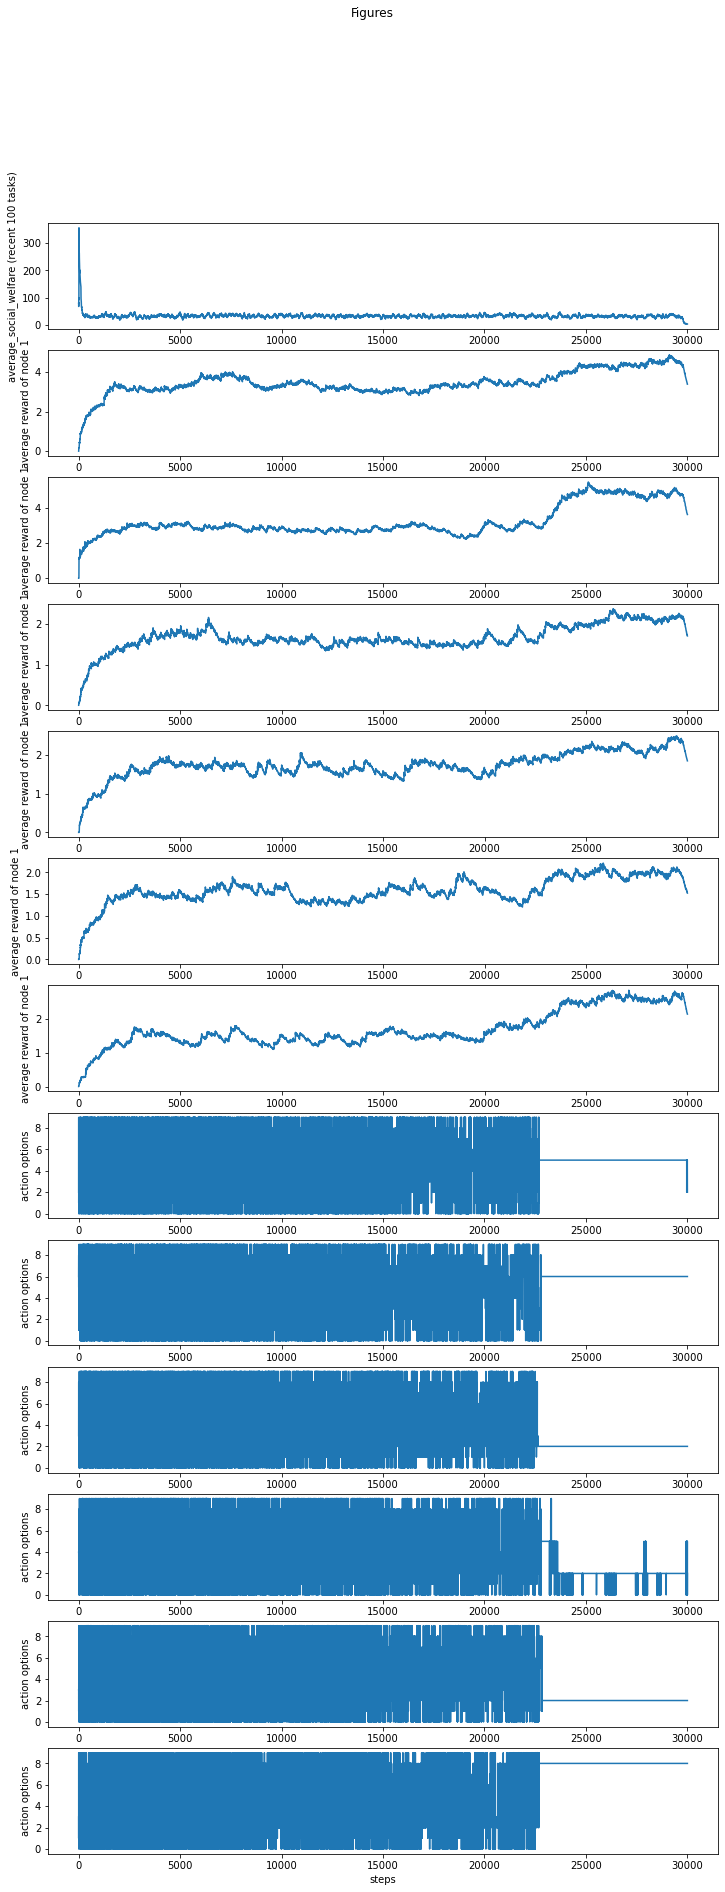

social welfare: 962258.1093415101
total value: 8703567.859293232


In [64]:
# set the parameters
(seed, mipgap, n_tasks, n_time, n_nodes, resource_coefficient, high_value_slackness, 
low_value_slackness, valuation_ratio, resource_ratio, p_high_value_task, avg_resource_capacity,
 avg_unit_cost, epsilons_tuple, epsilon_steps_tuple, auction_type) = set_parameters(30000)
num_actions=10
verbose=False

# train the agents
(sw_list, total_value, df_tasks_1, df_nodes, agents_list,
allocation_scheme) = train_multi_agent_sarsa(avg_resource_capacity, avg_unit_cost, 
                                        alpha=0.02,
            beta=0.001, epsilon_tuple=epsilons_tuple, epsilon_steps_tuple=epsilon_steps_tuple,
            high_value_proportion=p_high_value_task, num_actions=num_actions,
            time_length=n_time, total_number_of_steps=n_tasks, num_fog_nodes=6,
            valuation_coefficient_ratio=valuation_ratio,
            resource_ratio=resource_ratio, seed=seed, verbose=verbose,
            plot_bool=True, auction_type=auction_type)

# save the trained agents
filehandler = open(f"../trained_agents/reverse_auction_v1_seed={seed}_agents",
                   'wb')
pickle.dump(agents_list, filehandler)

# print the results
print("social welfare:", sw_list[-1])
print("total value:", total_value)

### Execution

New simulation data generated!


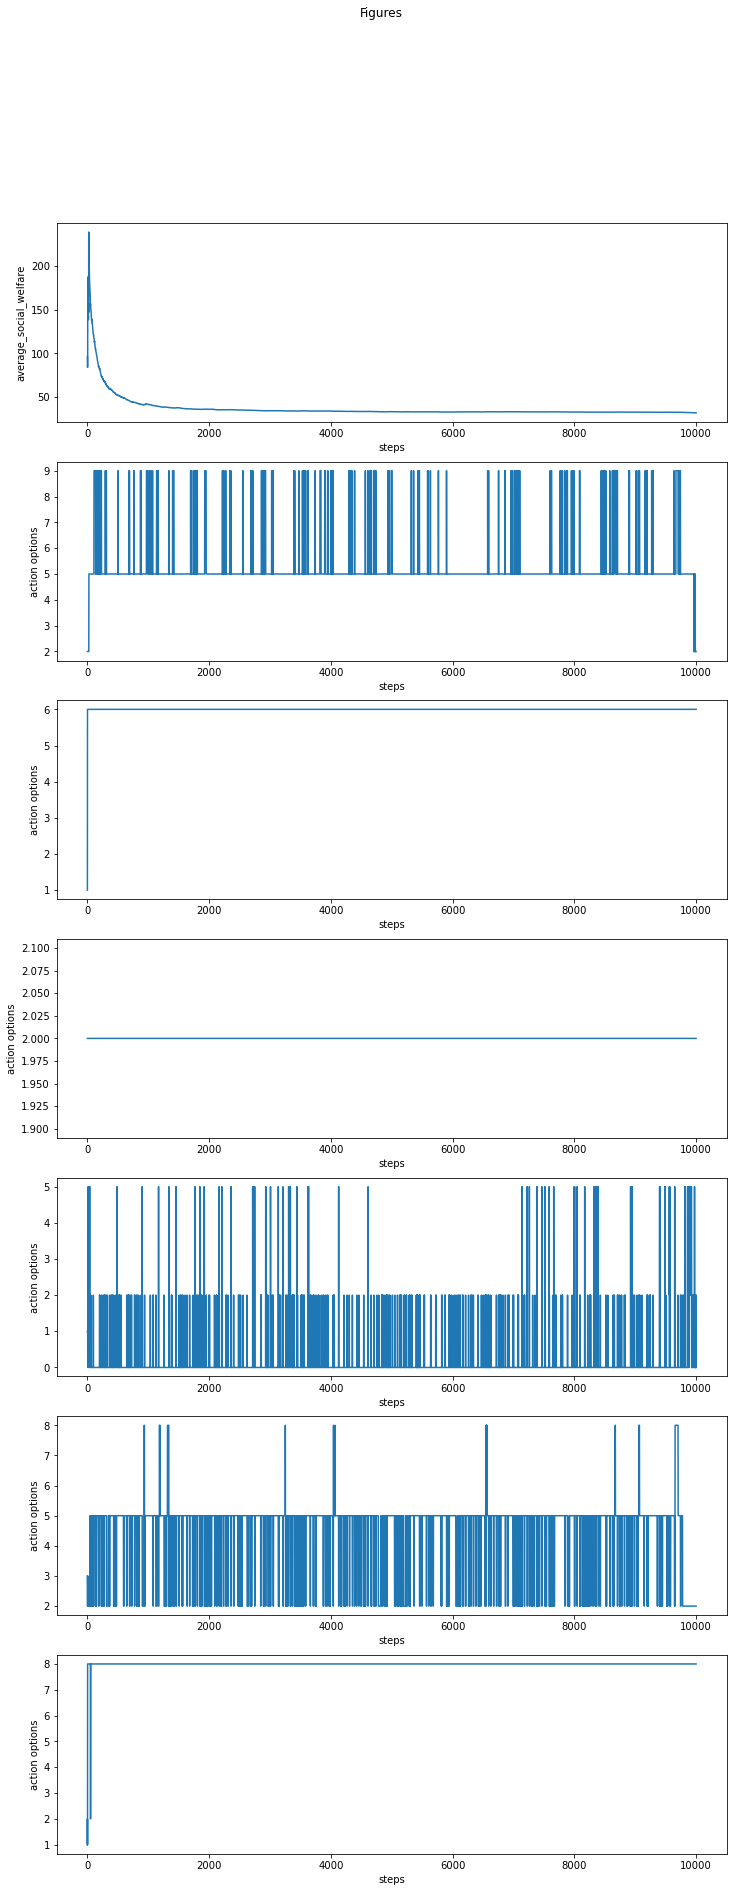

auction type = second-price
total value of tasks = 2877896.628532695
total social welfare = 316845.3481939015


In [66]:
# get the trained agents
filehandler = open(f"../trained_agents/reverse_auction_v1_seed={seed}_agents", 'rb')
agents_list = pickle.load(filehandler)

# set the parameters
(seed, mipgap, n_tasks, n_time, n_nodes, resource_coefficient, high_value_slackness, 
low_value_slackness, valuation_ratio, resource_ratio, p_high_value_task, avg_resource_capacity,
 avg_unit_cost, epsilons_tuple, epsilon_steps_tuple, auction_type) = set_parameters(10000)
num_trials=1

# allocate tasks:
sw_list, total_value, df_tasks_2, df_nodes, agents_list, allocation_scheme = \
    execute_multi_agent_sarsa(avg_resource_capacity, avg_unit_cost, num_actions=num_actions,
                              time_length=n_time,
                              high_value_proportion=p_high_value_task,
                              total_number_of_steps=n_tasks,
                              num_fog_nodes=6,
                              valuation_coefficient_ratio=valuation_ratio,
                              number_of_runs=num_trials, plot_bool=True,
                              bool_decay=True,
                              resource_ratio=resource_ratio,
                              agents_list=agents_list, training_seed=seed,
                              verbose=False, auction_type=auction_type)

sys.stdout = stdout
print(f"auction type = {auction_type}")
print(f"total value of tasks = {total_value}")
social_welfare = sw_list[-1]
print(f"total social welfare = {social_welfare}")
# social_welfare_partial = sw_list[int(number_of_tasks/3*2)] - sw_list[int(number_of_tasks/3)]
# print(f"social_welfare_partial={social_welfare_partial}")
# print(df_tasks_2.head())

In [55]:
raise SystemExit("Stop✋")

SystemExit: Stop✋

/Users/fan/anaconda3/envs/reverse-auction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [56]:
# make sure the tasks are the same.
df_tasks_2.head()
df_tasks.head()
df_tasks_2.tail()
df_tasks.tail()

,valuation_coefficient,arrive_time,start_time,deadline,usage_time,CPU,RAM,storage
0,60.800179,0.017895,1,9,2,2.230439,0.915901,3.170302
1,99.040218,0.018204,1,9,1,0.873625,1.170363,0.615647
2,81.773970,0.037144,1,8,1,0.365520,2.345342,1.441982
3,82.147670,0.062699,1,7,1,1.335054,0.803606,0.933253
4,55.452056,0.075715,1,10,2,2.427009,0.027723,0.289902


,valuation_coefficient,arrive_time,start_time,deadline,usage_time,CPU,RAM,DISK
0,60.800179,0.017895,1,9,2,2.230439,0.915901,3.170302
1,99.040218,0.018204,1,9,1,0.873625,1.170363,0.615647
2,81.773970,0.037144,1,8,1,0.365520,2.345342,1.441982
3,82.147670,0.062699,1,7,1,1.335054,0.803606,0.933253
4,55.452056,0.075715,1,10,2,2.427009,0.027723,0.289902


,valuation_coefficient,arrive_time,start_time,deadline,usage_time,CPU,RAM,storage
9995,57.236320,246.982993,247,249,1,1.587305,1.844032,1.203255
9996,573.043188,246.987396,247,249,4,3.479641,3.085269,3.905616
9997,67.101807,246.989283,247,249,1,0.248483,0.809779,0.837529
9998,55.642618,246.991113,247,249,2,2.438531,2.547483,1.086955
9999,660.559462,246.994554,247,249,4,3.406165,2.882961,3.753239


,valuation_coefficient,arrive_time,start_time,deadline,usage_time,CPU,RAM,DISK
9995,57.236320,246.982993,247,249,1,1.587305,1.844032,1.203255
9996,573.043188,246.987396,247,249,4,3.479641,3.085269,3.905616
9997,67.101807,246.989283,247,249,1,0.248483,0.809779,0.837529
9998,55.642618,246.991113,247,249,2,2.438531,2.547483,1.086955
9999,660.559462,246.994554,247,249,4,3.406165,2.882961,3.753239
